# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import spacy
import re


# Setup

In [ ]:
# Set seeds
np.random.seed(42)

# Read data

In [ ]:
df_train = pd.read_csv('metastatic_local_train.csv', converters={'accept': literal_eval})
df_test = pd.read_csv("metastatic_local_test.csv", converters={'accept': literal_eval})

In [4]:
# Create dummy variables from accept column
df_train = df_train.join(pd.get_dummies(df_train["accept"].explode()).groupby(level=0).sum())
df_test = df_test.join(pd.get_dummies(df_test["accept"].explode()).groupby(level=0).sum())


# Dataset characteristics

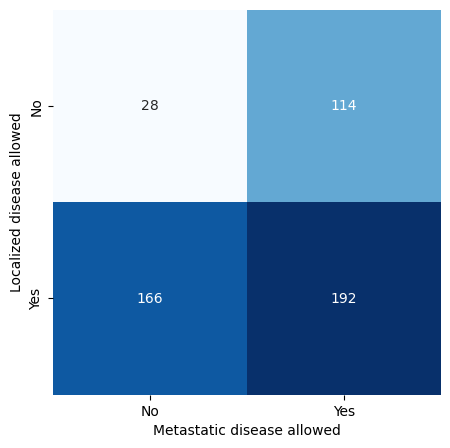

In [5]:
# Visualize the distribution of LOCAL and METASTATIC in the training set
fig = plt.figure(figsize=(5, 5))
train_cross_tab = pd.crosstab(df_train["LOCAL"], df_train["METASTATIC"])

sns.heatmap(train_cross_tab, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Metastatic disease allowed")
plt.ylabel("Localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/training_characteristics.png", dpi=300, bbox_inches="tight")

In [6]:
# Calculate percentages of respective fields in the training set

metastatic_and_local_train = 100 * train_cross_tab.loc[1, 1] / df_train.shape[0]
metastatic_not_local_train = 100 * train_cross_tab.loc[0, 1] / df_train.shape[0]
local_not_metastatic_train = 100 * train_cross_tab.loc[1, 0] / df_train.shape[0]
neither_train = 100 * train_cross_tab.loc[0, 0] / df_train.shape[0]
local_train = 100 * (metastatic_and_local_train + local_not_metastatic_train) / 100
metastatic_train = 100 * (metastatic_and_local_train + metastatic_not_local_train) / 100

print(f"Percentage of trials that allow both metastatic and localized disease: {metastatic_and_local_train:.2f}%")
print(f"Percentage of trials that allow metastatic disease but not localized disease: {metastatic_not_local_train:.2f}%")
print(f"Percentage of trials that allow localized disease but not metastatic disease: {local_not_metastatic_train:.2f}%")
print(f"Percentage of trials that allow neither metastatic nor localized disease: {neither_train:.2f}%")
print(f"Percentage of trials that allow localized disease: {local_train:.2f}%")
print(f"Percentage of trials that allow metastatic disease: {metastatic_train:.2f}%")

Percentage of trials that allow both metastatic and localized disease: 38.40%
Percentage of trials that allow metastatic disease but not localized disease: 22.80%
Percentage of trials that allow localized disease but not metastatic disease: 33.20%
Percentage of trials that allow neither metastatic nor localized disease: 5.60%
Percentage of trials that allow localized disease: 71.60%
Percentage of trials that allow metastatic disease: 61.20%


In [7]:
df_train["METASTATIC"].value_counts(normalize=True)

METASTATIC
1    0.612
0    0.388
Name: proportion, dtype: float64

In [8]:
df_train["LOCAL"].value_counts(normalize=True)

LOCAL
1    0.716
0    0.284
Name: proportion, dtype: float64

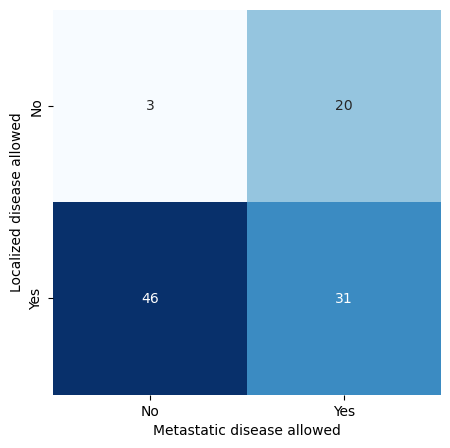

In [9]:
# Visualize the distribution of LOCAL and METASTATIC in the test set
fig = plt.figure(figsize=(5, 5))
test_cross_tab = pd.crosstab(df_test["LOCAL"], df_test["METASTATIC"])
sns.heatmap(test_cross_tab, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Metastatic disease allowed")
plt.ylabel("Localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/test_characteristics.png", dpi=300, bbox_inches="tight")

In [10]:
# Calculate percentages of respective fields in the test set

metastatic_and_local_test = 100 * test_cross_tab.loc[1, 1] / df_test.shape[0]
metastatic_not_local_test = 100 * test_cross_tab.loc[0, 1] / df_test.shape[0]
local_not_metastatic_test = 100 * test_cross_tab.loc[1, 0] / df_test.shape[0]
neither_test = 100 * test_cross_tab.loc[0, 0] / df_test.shape[0]
local_test = 100 * (metastatic_and_local_test + local_not_metastatic_test) / 100
metastatic_test = 100 * (metastatic_and_local_test + metastatic_not_local_test) / 100


print(
    f"Percentage of trials that allow both metastatic and localized disease: {metastatic_and_local_test:.2f}%"
)
print(
    f"Percentage of trials that allow metastatic disease but not localized disease: {metastatic_not_local_test:.2f}%"
)
print(
    f"Percentage of trials that allow localized disease but not metastatic disease: {local_not_metastatic_test:.2f}%"
)
print(
    f"Percentage of trials that allow neither metastatic nor localized disease: {neither_test:.2f}%"
)
print(
    f"Percentage of trials that allow localized disease: {local_test:.2f}%"
)
print(
    f"Percentage of trials that allow metastatic disease: {metastatic_test:.2f}%"
)


Percentage of trials that allow both metastatic and localized disease: 31.00%
Percentage of trials that allow metastatic disease but not localized disease: 20.00%
Percentage of trials that allow localized disease but not metastatic disease: 46.00%
Percentage of trials that allow neither metastatic nor localized disease: 3.00%
Percentage of trials that allow localized disease: 77.00%
Percentage of trials that allow metastatic disease: 51.00%


In [11]:
df_test["METASTATIC"].value_counts(normalize=True)

METASTATIC
1    0.51
0    0.49
Name: proportion, dtype: float64

In [12]:
df_test["LOCAL"].value_counts(normalize=True)

LOCAL
1    0.77
0    0.23
Name: proportion, dtype: float64

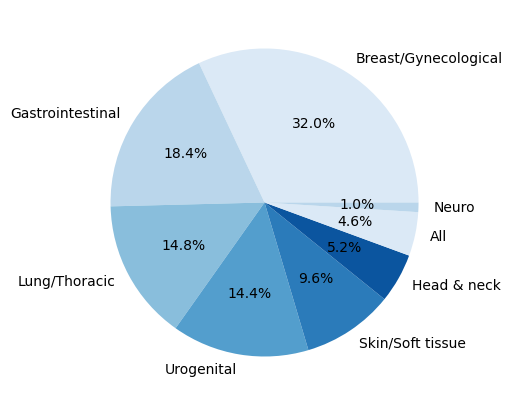

In [13]:
# Create a pie chart of the distribution of family in the training set using seaborn
fig = plt.figure(figsize=(5, 5))
sns.set_palette("Blues")
df_train["family"].value_counts().plot.pie(autopct="%1.1f%%")
plt.ylabel("")
plt.show()

fig.savefig("plots/family_distribution_train.png", dpi=300, bbox_inches="tight")

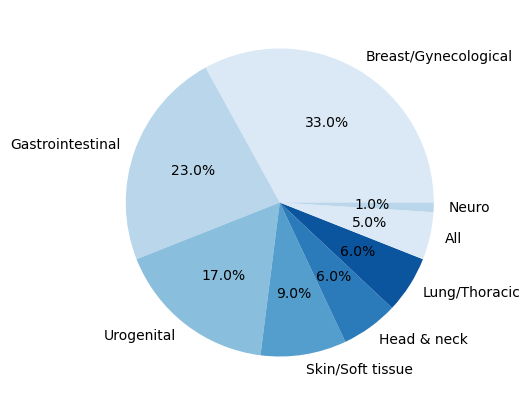

In [14]:
# Create a pie chart of the distribution of family in the test set using seaborn
fig = plt.figure(figsize=(5, 5))
sns.set_palette("Blues")
df_test["family"].value_counts().plot.pie(autopct="%1.1f%%")
plt.ylabel("")
plt.show()

fig.savefig("plots/family_distribution_test.png", dpi=300, bbox_inches="tight")


# Testing

## Make ML predictions

In [15]:
# Load model
metastatic_local_model = spacy.load("./metastatic_local_publication_v1/model-best")

/Users/paulwindisch/opt/anaconda3/envs/journal_nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Predict on the test set
def predict(text):
    prediction = metastatic_local_model(text)
    return prediction.cats

df_test["ML_prediction"] = df_test["text"].apply(predict)

# Create columns from the prediction dictionary
df_test["LOCAL_PREDICTED_ML"] = df_test["ML_prediction"].apply(
    lambda x: 1 if x["LOCAL"] > 0.5 else 0
)
df_test["METASTATIC_PREDICTED_ML"] = df_test["ML_prediction"].apply(
    lambda x: 1 if x["METASTATIC"] > 0.5 else 0
)

## Make regex predictions

In [17]:
def predict_metastatic_with_regex(title):
    title = title.lower()

    # Check for non-metastatic in the title
    if re.search(r"non[ -]?metast", title):
        return 0
    # Check for metastatic in the title
    if (
        re.search(r"metasta", title)
        and not re.search(r"non[- ]?metasta", title)
        and not re.search(r"metastas[ie]s[- ]free", title)
    ):
        return 1
    # Check for stage IV in the title
    if re.search(r"\biv\b", title):
        return 1
    # Check for stages other than IV in the title
    if (
        re.search(r"\bstage\b", title)
        and not (
            re.search(r"\biv", title)
            or re.search(r"extensive[- ]stage", title)
            or re.search(r"advanced[- ]stage", title)
            or re.search(r"\b4\b", title)
        )
    ):
        return 0
    # Check for advanced in the title
    if re.search(r"advanced", title) and not re.search(r"locally[- ]advanced", title):
        return 1
    # Check for extensive stage in the title
    if re.search(r"extensive[- ]stage", title):
        return 1
    # Make a random guess if none of the above conditions are met
    return np.random.choice([0, 1])


def predict_local_with_regex(title):
    title = title.lower()

    # Check for early breast and "or metastatic"
    if re.search(r"\bearly breast", title) or re.search(r"\bor metast", title):
        return 1

    # Check for stages other than IV
    if re.search(r"stage i[^v]", title):
        return 1

    # Check for non-metastatic
    if re.search(r"non[ -]?metast", title):
        return 1

    # Check for locally advanced
    if re.search(r"locally[- ]advanced", title) or re.search(r"locoregional", title):
        return 1
    # Make a random guess if none of the above conditions are met
    return np.random.choice([0, 1])


df_test["METASTATIC_PREDICTED_REGEX"] = df_test["title"].apply(predict_metastatic_with_regex)
df_test["LOCAL_PREDICTED_REGEX"] = df_test["title"].apply(predict_local_with_regex)

## Refine ML predictions with regex

In [18]:
def refine_metastatic_with_regex(row):
    title = row["title"].lower()
    # Check for non-metastatic in the title
    if row["METASTATIC_PREDICTED_ML"] == 1 and re.search(r"non[ -]?metast", title):
        return 0

    # Check for metastatic in the title
    if (
        row["METASTATIC_PREDICTED_ML"] == 0
        and re.search(r"metasta", title)
        and not re.search(r"non[- ]?metasta", title)
        and not re.search(r"metastas[ie]s[- ]free", title)
    ):
        return 1

    # Check for stage IV in the title
    if row["METASTATIC_PREDICTED_ML"] == 0 and re.search(r"\biv\b", title):
        return 1

    # Check for stages other than IV in the title
    if (
        row["METASTATIC_PREDICTED_ML"] == 1
        and re.search(r"\bstage\b", title)
        and not (
            re.search(r"\biv", title)
            or re.search(r"extensive[- ]stage", title)
            or re.search(r"advanced[- ]stage", title)
            or re.search(r"\b4\b", title)
        )
    ):
        return 0

    # Check for advanced in the title
    if row["METASTATIC_PREDICTED_ML"] == 0 and re.search(
        r"advanced", title
    ) and not re.search(r"locally[- ]advanced", title):
        return 1
    
    # Check for extensive stage in the title
    if row["METASTATIC_PREDICTED_ML"] == 0 and re.search(r"extensive[- ]stage", title):
        return 1
    
    # Return the ML prediction if no conditions are met
    return row["METASTATIC_PREDICTED_ML"]


def refine_local_with_regex(row):
    title = row["title"].lower()

    # Check for early breast and "or metastatic"
    if row["LOCAL_PREDICTED_ML"] == 0 and (re.search(r"\bearly breast", title) or re.search(r"\bor metast", title)):
        return 1

    # Check for stages other than IV
    if row["LOCAL_PREDICTED_ML"] == 0 and re.search(r"stage i[^v]", title):
        return 1

    # Check for non-metastatic
    if row["LOCAL_PREDICTED_ML"] == 0 and re.search(r"non[ -]?metast", title):
        return 1

    # Check for locally advanced
    if row["LOCAL_PREDICTED_ML"] == 0 and (
        re.search(r"locally[- ]advanced", title) or re.search(r"locoregional", title)
    ):
        return 1
    # Return the ML prediction if no conditions are met
    return row["LOCAL_PREDICTED_ML"]

df_test["METASTATIC_PREDICTED_COMBINED"] = df_test.apply(
    refine_metastatic_with_regex, axis=1
)
df_test["LOCAL_PREDICTED_COMBINED"] = df_test.apply(refine_local_with_regex, axis=1)

## Evaluate performance

In [19]:
# Create combined labels column for ground truth
df_test.loc[
    (df_test["LOCAL"] == 1) & (df_test["METASTATIC"] == 0), "ALL_LABELS"
] = "Local_only"
df_test.loc[(df_test["LOCAL"] == 0) & (df_test["METASTATIC"] == 1), "ALL_LABELS"] = (
    "Metastatic_only"
)
df_test.loc[(df_test["LOCAL"] == 1) & (df_test["METASTATIC"] == 1), "ALL_LABELS"] = (
    "Both"
)
df_test.loc[(df_test["LOCAL"] == 0) & (df_test["METASTATIC"] == 0), "ALL_LABELS"] = (
    "Neither"
)

# Create combined labels column for regex predictions
df_test.loc[
    (df_test["LOCAL_PREDICTED_REGEX"] == 1)
    & (df_test["METASTATIC_PREDICTED_REGEX"] == 0),
    "ALL_LABELS_PREDICTIONS_REGEX",
] = "Local_only"
df_test.loc[
    (df_test["LOCAL_PREDICTED_REGEX"] == 0)
    & (df_test["METASTATIC_PREDICTED_REGEX"] == 1),
    "ALL_LABELS_PREDICTIONS_REGEX",
] = "Metastatic_only"
df_test.loc[
    (df_test["LOCAL_PREDICTED_REGEX"] == 1)
    & (df_test["METASTATIC_PREDICTED_REGEX"] == 1),
    "ALL_LABELS_PREDICTIONS_REGEX",
] = "Both"
df_test.loc[
    (df_test["LOCAL_PREDICTED_REGEX"] == 0)
    & (df_test["METASTATIC_PREDICTED_REGEX"] == 0),
    "ALL_LABELS_PREDICTIONS_REGEX",
] = "Neither"

# Create combined labels columns for ML predictions
df_test.loc[
    (df_test["LOCAL_PREDICTED_ML"] == 1)
    & (df_test["METASTATIC_PREDICTED_ML"] == 0),
    "ALL_LABELS_PREDICTIONS_ML",
] = "Local_only"
df_test.loc[
    (df_test["LOCAL_PREDICTED_ML"] == 0)
    & (df_test["METASTATIC_PREDICTED_ML"] == 1),
    "ALL_LABELS_PREDICTIONS_ML",
] = "Metastatic_only"
df_test.loc[
    (df_test["LOCAL_PREDICTED_ML"] == 1)
    & (df_test["METASTATIC_PREDICTED_ML"] == 1),
    "ALL_LABELS_PREDICTIONS_ML",
] = "Both"
df_test.loc[
    (df_test["LOCAL_PREDICTED_ML"] == 0)
    & (df_test["METASTATIC_PREDICTED_ML"] == 0),
    "ALL_LABELS_PREDICTIONS_ML",
] = "Neither"

# Create combined labels columns for combined predictions
df_test.loc[
    (df_test["LOCAL_PREDICTED_COMBINED"] == 1)
    & (df_test["METASTATIC_PREDICTED_COMBINED"] == 0),
    "ALL_LABELS_PREDICTIONS_COMBINED",
] = "Local_only"
df_test.loc[
    (df_test["LOCAL_PREDICTED_COMBINED"] == 0)
    & (df_test["METASTATIC_PREDICTED_COMBINED"] == 1),
    "ALL_LABELS_PREDICTIONS_COMBINED",
] = "Metastatic_only"
df_test.loc[
    (df_test["LOCAL_PREDICTED_COMBINED"] == 1)
    & (df_test["METASTATIC_PREDICTED_COMBINED"] == 1),
    "ALL_LABELS_PREDICTIONS_COMBINED",
] = "Both"
df_test.loc[
    (df_test["LOCAL_PREDICTED_COMBINED"] == 0)
    & (df_test["METASTATIC_PREDICTED_COMBINED"] == 0),
    "ALL_LABELS_PREDICTIONS_COMBINED",
] = "Neither"


/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/3320345756.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Local_only' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[
/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/3320345756.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Local_only' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[
/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/3320345756.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Local_only' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[
/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/i

### ML predictions

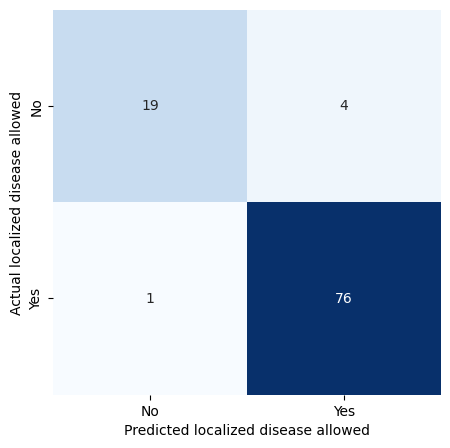

In [20]:
# Create confusion matrix of predicted and actual values for LOCAL
confusion_matrix = pd.crosstab(df_test["LOCAL"], df_test["LOCAL_PREDICTED_ML"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted localized disease allowed")
plt.ylabel("Actual localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_local_ML.png", dpi=300, bbox_inches="tight")

In [21]:
# Calculate the accuracy of the ML prediction for LOCAL
accuracy_local_ML = (
    np.sum(df_test["LOCAL"] == df_test["LOCAL_PREDICTED_ML"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_local_ML_std = np.sqrt(
    accuracy_local_ML * (1 - accuracy_local_ML) / df_test.shape[0]
)
accuracy_local_ML_CI = 1.96 * accuracy_local_ML_std
print(
    f"Accuracy of ML prediction for LOCAL: {accuracy_local_ML:.2f} (95% CI: {accuracy_local_ML - accuracy_local_ML_CI:.2f} - {accuracy_local_ML + accuracy_local_ML_CI:.2f})"
)

# Calculate the precision of the ML prediction for LOCAL
precision_local_ml = (
    np.sum(
        (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["LOCAL_PREDICTED_ML"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_local_ml_std = np.sqrt(
    precision_local_ml * (1 - precision_local_ml) / np.sum(df_test["LOCAL_PREDICTED_ML"] == 1)
)
precision_local_ml_CI = 1.96 * precision_local_ml_std
print(f"Precision of ML prediction for LOCAL: {precision_local_ml:.2f} (95% CI: {precision_local_ml - precision_local_ml_CI:.2f} - {precision_local_ml + precision_local_ml_CI:.2f})")

# Calculate the recall of the ML prediction for LOCAL
recall_local_ml = (
    np.sum(
        (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["LOCAL"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_local_ml_std = np.sqrt(
    recall_local_ml * (1 - recall_local_ml) / np.sum(df_test["LOCAL"] == 1)
)
recall_local_ml_CI = 1.96 * recall_local_ml_std
print(
    f"Recall of ML prediction for LOCAL: {recall_local_ml:.2f} (95% CI: {recall_local_ml - recall_local_ml_CI:.2f} - {recall_local_ml + recall_local_ml_CI:.2f})"
)

# Calculate the F1 score of the ML prediction for LOCAL
f1_local_ml = 2 * precision_local_ml * recall_local_ml / (precision_local_ml + recall_local_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_local_ml_std = np.sqrt(
    f1_local_ml * (1 - f1_local_ml) / df_test.shape[0]
)
f1_local_ml_CI = 1.96 * f1_local_ml_std
print(f"F1 score of ML prediction for LOCAL: {f1_local_ml:.2f} (95% CI: {f1_local_ml - f1_local_ml_CI:.2f} - {f1_local_ml + f1_local_ml_CI:.2f})")



Accuracy of ML prediction for LOCAL: 0.95 (95% CI: 0.91 - 0.99)
Precision of ML prediction for LOCAL: 0.95 (95% CI: 0.90 - 1.00)
Recall of ML prediction for LOCAL: 0.99 (95% CI: 0.96 - 1.01)
F1 score of ML prediction for LOCAL: 0.97 (95% CI: 0.93 - 1.00)


In [22]:
# Calculate the accuracy per family of the ML prediction for LOCAL
accuracy_local_ml_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["LOCAL"] == x["LOCAL_PREDICTED_ML"]) / x.shape[0]
)

# Calculate the precision per family of the ML prediction for LOCAL
precision_local_ml_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_ML"] == 1)) / np.sum(x["LOCAL_PREDICTED_ML"] == 1)
)

# Calculate the recall per family of the ML prediction for LOCAL
recall_local_ml_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_ML"] == 1)) / np.sum(x["LOCAL"] == 1)
)

# Calculate the F1 score per family of the ML prediction for LOCAL
f1_local_ml_per_family = 2 * precision_local_ml_per_family * recall_local_ml_per_family / (precision_local_ml_per_family + recall_local_ml_per_family)
# Round the F1 values to two decimal places
f1_local_ml_per_family = f1_local_ml_per_family.round(2)
f1_local_ml_per_family


family
All                     1.00
Breast/Gynecological    1.00
Gastrointestinal        0.92
Head & neck             1.00
Lung/Thoracic           0.91
Neuro                   1.00
Skin/Soft tissue        0.93
Urogenital              0.96
dtype: float64

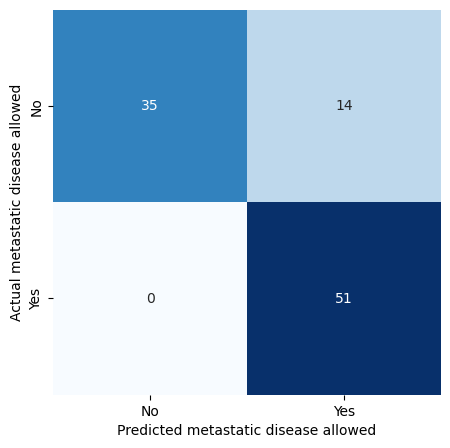

In [23]:
# Create confusion matrix of predicted and actual values for METASTATIC
confusion_matrix = pd.crosstab(df_test["METASTATIC"], df_test["METASTATIC_PREDICTED_ML"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted metastatic disease allowed")
plt.ylabel("Actual metastatic disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_metastatic_ML.png", dpi=300, bbox_inches="tight")

In [24]:
# Calculate the accuracy of the ML prediction for METASTATIC
accuracy_metastatic_ml = (
    np.sum(df_test["METASTATIC"] == df_test["METASTATIC_PREDICTED_ML"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_metastatic_ml_std = np.sqrt(
    accuracy_metastatic_ml * (1 - accuracy_metastatic_ml) / df_test.shape[0]
)
accuracy_metastatic_ml_CI = 1.96 * accuracy_metastatic_ml_std
print(
    f"Accuracy of ML prediction for METASTATIC: {accuracy_metastatic_ml:.2f} (95% CI: {accuracy_metastatic_ml - accuracy_metastatic_ml_CI:.2f} - {accuracy_metastatic_ml + accuracy_metastatic_ml_CI:.2f})"
)

# Calculate the precision of the ML prediction for METASTATIC
precision_metastatic_ml = (
    np.sum(
        (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["METASTATIC_PREDICTED_ML"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_metastatic_ml_std = np.sqrt(
    precision_metastatic_ml * (1 - precision_metastatic_ml) / np.sum(df_test["METASTATIC_PREDICTED_ML"] == 1)
)
precision_metastatic_ml_CI = 1.96 * precision_metastatic_ml_std
print(f"Precision of ML prediction for METASTATIC: {precision_metastatic_ml:.2f} (95% CI: {precision_metastatic_ml - precision_metastatic_ml_CI:.2f} - {precision_metastatic_ml + precision_metastatic_ml_CI:.2f})")

# Calculate the recall of the ML prediction for METASTATIC
recall_metastatic_ml = (
    np.sum(
        (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["METASTATIC"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_metastatic_ml_std = np.sqrt(
    recall_metastatic_ml * (1 - recall_metastatic_ml) / np.sum(df_test["METASTATIC"] == 1)
)
recall_metastatic_ml_CI = 1.96 * recall_metastatic_ml_std
print(
    f"Recall of ML prediction for METASTATIC: {recall_metastatic_ml:.2f} (95% CI: {recall_metastatic_ml - recall_metastatic_ml_CI:.2f} - {recall_metastatic_ml + recall_metastatic_ml_CI:.2f})"
)

# Calculate the F1 score of the ML prediction for METASTATIC
f1_metastatic_ml = 2 * precision_metastatic_ml * recall_metastatic_ml / (precision_metastatic_ml + recall_metastatic_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_ml_std = np.sqrt(
    f1_metastatic_ml * (1 - f1_metastatic_ml) / df_test.shape[0]
)
f1_metastatic_ml_CI = 1.96 * f1_metastatic_ml_std
print(f"F1 score of ML prediction for METASTATIC: {f1_metastatic_ml:.2f} (95% CI: {f1_metastatic_ml - f1_metastatic_ml_CI:.2f} - {f1_metastatic_ml + f1_metastatic_ml_CI:.2f})")

Accuracy of ML prediction for METASTATIC: 0.86 (95% CI: 0.79 - 0.93)
Precision of ML prediction for METASTATIC: 0.78 (95% CI: 0.68 - 0.88)
Recall of ML prediction for METASTATIC: 1.00 (95% CI: 1.00 - 1.00)
F1 score of ML prediction for METASTATIC: 0.88 (95% CI: 0.82 - 0.94)


In [25]:
# Calculate the accuracy per family of the ML prediction for METASTATIC
accuracy_metastatic_ml_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["METASTATIC"] == x["METASTATIC_PREDICTED_ML"]) / x.shape[0]
)

# Calculate the precision per family of the ML prediction for METASTATIC
precision_metastatic_ml_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_ML"] == 1)) / np.sum(x["METASTATIC_PREDICTED_ML"] == 1)
)

# Calculate the recall per family of the ML prediction for METASTATIC
recall_metastatic_ml_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_ML"] == 1)) / np.sum(x["METASTATIC"] == 1)
)

# Calculate the F1 score per family of the ML prediction for METASTATIC
f1_metastatic_ml_per_family = 2 * precision_metastatic_ml_per_family * recall_metastatic_ml_per_family / (precision_metastatic_ml_per_family + recall_metastatic_ml_per_family)

# Round the F1 values to two decimal places
f1_metastatic_ml_per_family = f1_metastatic_ml_per_family.round(2)
f1_metastatic_ml_per_family

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/390234639.py:8: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_ML"] == 1)) / np.sum(x["METASTATIC_PREDICTED_ML"] == 1)
/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/390234639.py:13: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_ML"] == 1)) / np.sum(x["METASTATIC"] == 1)


family
All                     1.00
Breast/Gynecological    0.92
Gastrointestinal        0.90
Head & neck             1.00
Lung/Thoracic           0.86
Neuro                    NaN
Skin/Soft tissue        0.77
Urogenital              0.75
dtype: float64

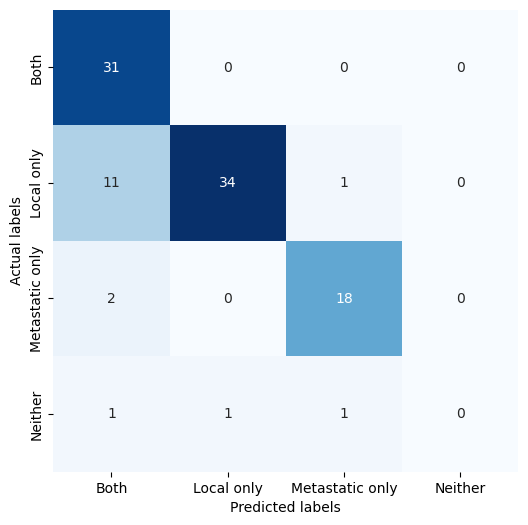

In [26]:
# Create the confusion matrix of predicted and actual values for combined labels
confusion_matrix = pd.crosstab(
    df_test["ALL_LABELS"], df_test["ALL_LABELS_PREDICTIONS_ML"]
)

# Add a column called "Neither" and fill it with zeros if it does not exist
if "Neither" not in confusion_matrix.columns:
    confusion_matrix["Neither"] = 0
    

# Plot the confusion matrix
fig = plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")


plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("plots/confusion_matrix_all_labels_ml.png", dpi=300, bbox_inches="tight")

In [44]:
df_test["ALL_LABELS"].value_counts(normalize=True)

ALL_LABELS
Local_only         0.46
Both               0.31
Metastatic_only    0.20
Neither            0.03
Name: proportion, dtype: float64

In [49]:
# Calculate the accuracy of the ML model for all labels
accuracy_combined_ml = (
    np.sum(df_test["ALL_LABELS"] == df_test["ALL_LABELS_PREDICTIONS_ML"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_combined_ml_std = np.sqrt(
    accuracy_combined_ml * (1 - accuracy_combined_ml) / df_test.shape[0]
)

accuracy_combined_ml_CI = 1.96 * accuracy_combined_ml_std
print(
    f"Accuracy of ML prediction for Both: {accuracy_combined_ml:.2f} (95% CI: {accuracy_combined_ml - accuracy_both_ml_CI:.2f} - {accuracy_combined_ml + accuracy_both_ml_CI:.2f})"
)
print("##############################################")

# Calculate the precision of the ML model for Both
precision_both_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Both") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Both")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Both")
)

# Estimate the 95 % confidence interval for the precision
precision_both_ml_std = np.sqrt(
    precision_both_ml * (1 - precision_both_ml) / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Both")
)
precision_both_ml_CI = 1.96 * precision_both_ml_std
print(f"Precision of ML prediction for Both: {precision_both_ml:.2f} (95% CI: {precision_both_ml - precision_both_ml_CI:.2f} - {precision_both_ml + precision_both_ml_CI:.2f})")

# Calculate the recall of the ML model for Both
recall_both_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Both") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Both")
    )
    / np.sum(df_test["ALL_LABELS"] == "Both")
)

# Estimate the 95 % confidence interval for the recall
recall_both_ml_std = np.sqrt(
    recall_both_ml * (1 - recall_both_ml) / np.sum(df_test["ALL_LABELS"] == "Both")
)
recall_both_ml_CI = 1.96 * recall_both_ml_std
print(
    f"Recall of ML prediction for Both: {recall_both_ml:.2f} (95% CI: {recall_both_ml - recall_both_ml_CI:.2f} - {recall_both_ml + recall_both_ml_CI:.2f})"
)

# Calculate the F1 score of the ML model for Both
f1_both_ml = 2 * precision_both_ml * recall_both_ml / (precision_both_ml + recall_both_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_both_ml_std = np.sqrt(
    f1_both_ml * (1 - f1_both_ml) / df_test.shape[0]
)
f1_both_ml_CI = 1.96 * f1_both_ml_std
print(f"F1 score of ML prediction for Both: {f1_both_ml:.2f} (95% CI: {f1_both_ml - f1_both_ml_CI:.2f} - {f1_both_ml + f1_both_ml_CI:.2f})")
print("##############################################")

# Calculate the precision of the ML model for Local only
precision_local_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Local_only") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Local_only")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Local_only")
)

# Estimate the 95 % confidence interval for the precision
precision_local_ml_std = np.sqrt(
    precision_local_ml * (1 - precision_local_ml) / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Local_only")
)
precision_local_ml_CI = 1.96 * precision_local_ml_std
print(f"Precision of ML prediction for Local only: {precision_local_ml:.2f} (95% CI: {precision_local_ml - precision_local_ml_CI:.2f} - {precision_local_ml + precision_local_ml_CI:.2f})")

# Calculate the recall of the ML model for Local only
recall_local_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Local_only") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Local_only")
    )
    / np.sum(df_test["ALL_LABELS"] == "Local_only")
)

# Estimate the 95 % confidence interval for the recall
recall_local_ml_std = np.sqrt(
    recall_local_ml * (1 - recall_local_ml) / np.sum(df_test["ALL_LABELS"] == "Local_only")
)
recall_local_ml_CI = 1.96 * recall_local_ml_std
print(
    f"Recall of ML prediction for Local only: {recall_local_ml:.2f} (95% CI: {recall_local_ml - recall_local_ml_CI:.2f} - {recall_local_ml + recall_local_ml_CI:.2f})"
)

# Calculate the F1 score of the ML model for Local only
f1_local_ml = 2 * precision_local_ml * recall_local_ml / (precision_local_ml + recall_local_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_local_ml_std = np.sqrt(
    f1_local_ml * (1 - f1_local_ml) / df_test.shape[0]
)
f1_local_ml_CI = 1.96 * f1_local_ml_std
print(f"F1 score of ML prediction for Local only: {f1_local_ml:.2f} (95% CI: {f1_local_ml - f1_local_ml_CI:.2f} - {f1_local_ml + f1_local_ml_CI:.2f})")
print("##############################################")

# Calculate the precision of the ML model for Metastatic only
precision_metastatic_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Metastatic_only") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Metastatic_only")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Metastatic_only")
)

# Estimate the 95 % confidence interval for the precision
precision_metastatic_ml_std = np.sqrt(
    precision_metastatic_ml * (1 - precision_metastatic_ml) / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Metastatic_only")
)
precision_metastatic_ml_CI = 1.96 * precision_metastatic_ml_std
print(f"Precision of ML prediction for Metastatic only: {precision_metastatic_ml:.2f} (95% CI: {precision_metastatic_ml - precision_metastatic_ml_CI:.2f} - {precision_metastatic_ml + precision_metastatic_ml_CI:.2f})")

# Calculate the recall of the ML model for Metastatic only
recall_metastatic_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Metastatic_only") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Metastatic_only")
    )
    / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")
)

# Estimate the 95 % confidence interval for the recall
recall_metastatic_ml_std = np.sqrt(
    recall_metastatic_ml * (1 - recall_metastatic_ml) / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")
)
recall_metastatic_ml_CI = 1.96 * recall_metastatic_ml_std
print(
    f"Recall of ML prediction for Metastatic only: {recall_metastatic_ml:.2f} (95% CI: {recall_metastatic_ml - recall_metastatic_ml_CI:.2f} - {recall_metastatic_ml + recall_metastatic_ml_CI:.2f})"
)

# Calculate the F1 score of the ML model for Metastatic only
f1_metastatic_ml = 2 * precision_metastatic_ml * recall_metastatic_ml / (precision_metastatic_ml + recall_metastatic_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_ml_std = np.sqrt(
    f1_metastatic_ml * (1 - f1_metastatic_ml) / df_test.shape[0]
)
f1_metastatic_ml_CI = 1.96 * f1_metastatic_ml_std
print(f"F1 score of ML prediction for Metastatic only: {f1_metastatic_ml:.2f} (95% CI: {f1_metastatic_ml - f1_metastatic_ml_CI:.2f} - {f1_metastatic_ml + f1_metastatic_ml_CI:.2f})")
print("##############################################")

# Calculate the precision of the ML model for Neither
precision_neither_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Neither")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Neither")
)

# Estimate the 95 % confidence interval for the precision
precision_neither_ml_std = np.sqrt(
    precision_neither_ml * (1 - precision_neither_ml) / np.sum(df_test["ALL_LABELS_PREDICTIONS_ML"] == "Neither")
)
precision_neither_ml_CI = 1.96 * precision_neither_ml_std
print(f"Precision of ML prediction for Neither: {precision_neither_ml:.2f} (95% CI: {precision_neither_ml - precision_neither_ml_CI:.2f} - {precision_neither_ml + precision_neither_ml_CI:.2f})")

# Calculate the recall of the ML model for Neither
recall_neither_ml = (
    np.sum(
        (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_PREDICTIONS_ML"] == "Neither")
    )
    / np.sum(df_test["ALL_LABELS"] == "Neither")
)

# Estimate the 95 % confidence interval for the recall
recall_neither_ml_std = np.sqrt(
    recall_neither_ml * (1 - recall_neither_ml) / np.sum(df_test["ALL_LABELS"] == "Neither")
)
recall_neither_ml_CI = 1.96 * recall_neither_ml_std
print(
    f"Recall of ML prediction for Neither: {recall_neither_ml:.2f} (95% CI: {recall_neither_ml - recall_neither_ml_CI:.2f} - {recall_neither_ml + recall_neither_ml_CI:.2f})"
)

# Calculate the F1 score of the ML model for Neither
f1_neither_ml = 2 * precision_neither_ml * recall_neither_ml / (precision_neither_ml + recall_neither_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_neither_ml_std = np.sqrt(
    f1_neither_ml * (1 - f1_neither_ml) / df_test.shape[0]
)
f1_neither_ml_CI = 1.96 * f1_neither_ml_std
print(f"F1 score of ML prediction for Neither: {f1_neither_ml:.2f} (95% CI: {f1_neither_ml - f1_neither_ml_CI:.2f} - {f1_neither_ml + f1_neither_ml_CI:.2f})")

Accuracy of ML prediction for Both: 0.83 (95% CI: 0.76 - 0.90)
##############################################
Precision of ML prediction for Both: 0.69 (95% CI: 0.55 - 0.82)
Recall of ML prediction for Both: 1.00 (95% CI: 1.00 - 1.00)
F1 score of ML prediction for Both: 0.82 (95% CI: 0.74 - 0.89)
##############################################
Precision of ML prediction for Local only: 0.97 (95% CI: 0.92 - 1.03)
Recall of ML prediction for Local only: 0.74 (95% CI: 0.61 - 0.87)
F1 score of ML prediction for Local only: 0.84 (95% CI: 0.77 - 0.91)
##############################################
Precision of ML prediction for Metastatic only: 0.90 (95% CI: 0.77 - 1.03)
Recall of ML prediction for Metastatic only: 0.90 (95% CI: 0.77 - 1.03)
F1 score of ML prediction for Metastatic only: 0.90 (95% CI: 0.84 - 0.96)
##############################################
Precision of ML prediction for Neither: nan (95% CI: nan - nan)
Recall of ML prediction for Neither: 0.00 (95% CI: 0.00 - 0.00)
F1 sco

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/402867315.py:149: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(


### Regex predictions

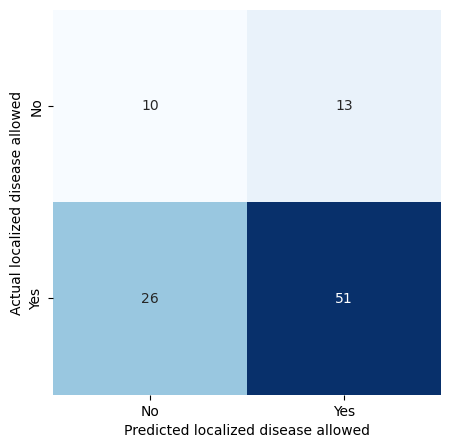

In [27]:
# Create confusion matrix of predicted and actual values for LOCAL using regex
confusion_matrix = pd.crosstab(df_test["LOCAL"], df_test["LOCAL_PREDICTED_REGEX"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted localized disease allowed")
plt.ylabel("Actual localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_local_regex.png", dpi=300, bbox_inches="tight")

In [28]:
# Calculate the accuracy of the regex prediction for LOCAL
accuracy_local_regex = (
    np.sum(df_test["LOCAL"] == df_test["LOCAL_PREDICTED_REGEX"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_local_regex_std = np.sqrt(
    accuracy_local_regex * (1 - accuracy_local_regex) / df_test.shape[0]
)
accuracy_local_regex_CI = 1.96 * accuracy_local_regex_std
print(
    f"Accuracy of regex prediction for LOCAL: {accuracy_local_regex:.2f} (95% CI: {accuracy_local_regex - accuracy_local_regex_CI:.2f} - {accuracy_local_regex + accuracy_local_regex_CI:.2f})"
)

# Calculate the precision of the regex prediction for LOCAL
precision_local_regex = (
    np.sum(
        (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_REGEX"] == 1)
    )
    / np.sum(df_test["LOCAL_PREDICTED_REGEX"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_local_regex_std = np.sqrt(
    precision_local_regex * (1 - precision_local_regex) / np.sum(df_test["LOCAL_PREDICTED_REGEX"] == 1)
)
precision_local_regex_CI = 1.96 * precision_local_regex_std
print(f"Precision of regex prediction for LOCAL: {precision_local_regex:.2f} (95% CI: {precision_local_regex - precision_local_regex_CI:.2f} - {precision_local_regex + precision_local_regex_CI:.2f})")

# Calculate the recall of the regex prediction for LOCAL
recall_local_regex = (
    np.sum(
        (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_REGEX"] == 1)
    )
    / np.sum(df_test["LOCAL"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_local_regex_std = np.sqrt(
    recall_local_regex * (1 - recall_local_regex) / np.sum(df_test["LOCAL"] == 1)
)
recall_local_regex_CI = 1.96 * recall_local_regex_std
print(
    f"Recall of regex prediction for LOCAL: {recall_local_regex:.2f} (95% CI: {recall_local_regex - recall_local_regex_CI:.2f} - {recall_local_regex + recall_local_regex_CI:.2f})"
)

# Calculate the F1 score of the regex prediction for LOCAL
f1_local_regex = 2 * precision_local_regex * recall_local_regex / (precision_local_regex + recall_local_regex)

# Estimate the 95 % confidence interval for the F1 score
f1_local_regex_std = np.sqrt(
    f1_local_regex * (1 - f1_local_regex) / df_test.shape[0]
)
f1_local_regex_CI = 1.96 * f1_local_regex_std
print(f"F1 score of regex prediction for LOCAL: {f1_local_regex:.2f} (95% CI: {f1_local_regex - f1_local_regex_CI:.2f} - {f1_local_regex + f1_local_regex_CI:.2f})")

Accuracy of regex prediction for LOCAL: 0.61 (95% CI: 0.51 - 0.71)
Precision of regex prediction for LOCAL: 0.80 (95% CI: 0.70 - 0.90)
Recall of regex prediction for LOCAL: 0.66 (95% CI: 0.56 - 0.77)
F1 score of regex prediction for LOCAL: 0.72 (95% CI: 0.64 - 0.81)


In [29]:
# Calculate the accuracy per family of the regex prediction for LOCAL
accuracy_local_regex_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["LOCAL"] == x["LOCAL_PREDICTED_REGEX"]) / x.shape[0]
)

# Calculate the precision per family of the regex prediction for LOCAL
precision_local_regex_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_REGEX"] == 1)) / np.sum(x["LOCAL_PREDICTED_REGEX"] == 1)
)

# Calculate the recall per family of the regex prediction for LOCAL
recall_local_regex_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_REGEX"] == 1)) / np.sum(x["LOCAL"] == 1)
)

# Calculate the F1 score per family of the regex prediction for LOCAL
f1_local_regex_per_family = 2 * precision_local_regex_per_family * recall_local_regex_per_family / (precision_local_regex_per_family + recall_local_regex_per_family)
# Round the F1 values to two decimal places
f1_local_regex_per_family = f1_local_regex_per_family.round(2)
f1_local_regex_per_family

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/2475532450.py:8: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_REGEX"] == 1)) / np.sum(x["LOCAL_PREDICTED_REGEX"] == 1)


family
All                     0.89
Breast/Gynecological    0.71
Gastrointestinal        0.62
Head & neck             0.91
Lung/Thoracic           0.89
Neuro                    NaN
Skin/Soft tissue        0.71
Urogenital              0.70
dtype: float64

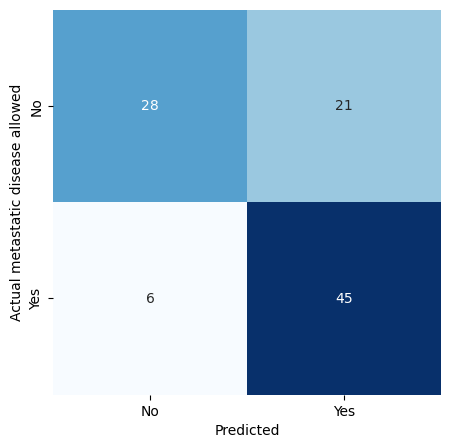

In [30]:
# Create confusion matrix of predicted and actual values for METASTATIC using regex
confusion_matrix = pd.crosstab(df_test["METASTATIC"], df_test["METASTATIC_PREDICTED_REGEX"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual metastatic disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_metastatic_regex.png", dpi=300, bbox_inches="tight")

In [31]:
# Calculate the accuracy of the regex prediction for METASTATIC
accuracy_metastatic_regex = (
    np.sum(df_test["METASTATIC"] == df_test["METASTATIC_PREDICTED_REGEX"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_metastatic_regex_std = np.sqrt(
    accuracy_metastatic_regex * (1 - accuracy_metastatic_regex) / df_test.shape[0]
)
accuracy_metastatic_regex_CI = 1.96 * accuracy_metastatic_regex_std
print(
    f"Accuracy of regex prediction for METASTATIC: {accuracy_metastatic_regex:.2f} (95% CI: {accuracy_metastatic_regex - accuracy_metastatic_regex_CI:.2f} - {accuracy_metastatic_regex + accuracy_metastatic_regex_CI:.2f})"
)

# Calculate the precision of the regex prediction for METASTATIC
precision_metastatic_regex = (
    np.sum(
        (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_REGEX"] == 1)
    )
    / np.sum(df_test["METASTATIC_PREDICTED_REGEX"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_metastatic_regex_std = np.sqrt(
    precision_metastatic_regex * (1 - precision_metastatic_regex) / np.sum(df_test["METASTATIC_PREDICTED_REGEX"] == 1)
)
precision_metastatic_regex_CI = 1.96 * precision_metastatic_regex_std
print(f"Precision of regex prediction for METASTATIC: {precision_metastatic_regex:.2f} (95% CI: {precision_metastatic_regex - precision_metastatic_regex_CI:.2f} - {precision_metastatic_regex + precision_metastatic_regex_CI:.2f})")

# Calculate the recall of the regex prediction for METASTATIC
recall_metastatic_regex = (
    np.sum(
        (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_REGEX"] == 1)
    )
    / np.sum(df_test["METASTATIC"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_metastatic_regex_std = np.sqrt(
    recall_metastatic_regex * (1 - recall_metastatic_regex) / np.sum(df_test["METASTATIC"] == 1)
)
recall_metastatic_regex_CI = 1.96 * recall_metastatic_regex_std
print(
    f"Recall of regex prediction for METASTATIC: {recall_metastatic_regex:.2f} (95% CI: {recall_metastatic_regex - recall_metastatic_regex_CI:.2f} - {recall_metastatic_regex + recall_metastatic_regex_CI:.2f})"
)

# Calculate the F1 score of the regex prediction for METASTATIC
f1_metastatic_regex = 2 * precision_metastatic_regex * recall_metastatic_regex / (precision_metastatic_regex + recall_metastatic_regex)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_regex_std = np.sqrt(
    f1_metastatic_regex * (1 - f1_metastatic_regex) / df_test.shape[0]
)
f1_metastatic_regex_CI = 1.96 * f1_metastatic_regex_std
print(f"F1 score of regex prediction for METASTATIC: {f1_metastatic_regex:.2f} (95% CI: {f1_metastatic_regex - f1_metastatic_regex_CI:.2f} - {f1_metastatic_regex + f1_metastatic_regex_CI:.2f})")


Accuracy of regex prediction for METASTATIC: 0.73 (95% CI: 0.64 - 0.82)
Precision of regex prediction for METASTATIC: 0.68 (95% CI: 0.57 - 0.79)
Recall of regex prediction for METASTATIC: 0.88 (95% CI: 0.79 - 0.97)
F1 score of regex prediction for METASTATIC: 0.77 (95% CI: 0.69 - 0.85)


In [32]:
# Calculate the accuracy per family of the regex prediction for METASTATIC
accuracy_metastatic_regex_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["METASTATIC"] == x["METASTATIC_PREDICTED_REGEX"]) / x.shape[0]
)

# Calculate the precision per family of the regex prediction for METASTATIC
precision_metastatic_regex_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_REGEX"] == 1)) / np.sum(x["METASTATIC_PREDICTED_REGEX"] == 1)
)

# Calculate the recall per family of the regex prediction for METASTATIC
recall_metastatic_regex_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_REGEX"] == 1)) / np.sum(x["METASTATIC"] == 1)
)

# Calculate the F1 score per family of the regex prediction for METASTATIC
f1_metastatic_regex_per_family = 2 * precision_metastatic_regex_per_family * recall_metastatic_regex_per_family / (precision_metastatic_regex_per_family + recall_metastatic_regex_per_family)
# Round the F1 values to two decimal places
f1_metastatic_regex_per_family = f1_metastatic_regex_per_family.round(2)
f1_metastatic_regex_per_family

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/2271552205.py:13: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_REGEX"] == 1)) / np.sum(x["METASTATIC"] == 1)


family
All                     0.57
Breast/Gynecological    0.79
Gastrointestinal        0.84
Head & neck             0.67
Lung/Thoracic           1.00
Neuro                    NaN
Skin/Soft tissue        0.73
Urogenital              0.71
dtype: float64

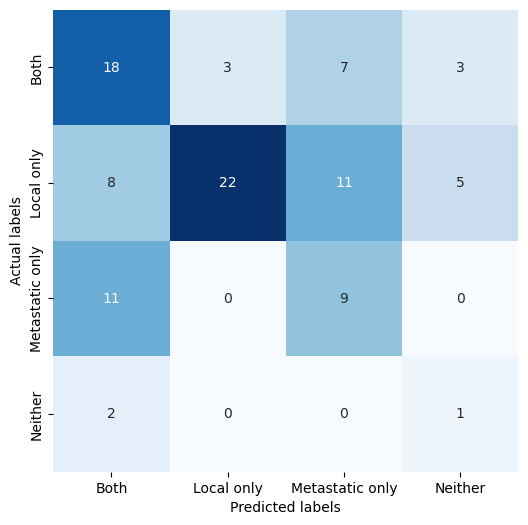

In [33]:
# Create the confusion matrix of predicted and actual values for combined labels
confusion_matrix = pd.crosstab(
    df_test["ALL_LABELS"], df_test["ALL_LABELS_PREDICTIONS_REGEX"]
)

# Plot the confusion matrix
fig = plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("plots/confusion_matrix_all_labels_regex.png", dpi=300, bbox_inches="tight")

In [50]:
# Calculate the accuracy of the regex model for all labels
accuracy_combined_regex = (
    np.sum(df_test["ALL_LABELS"] == df_test["ALL_LABELS_PREDICTIONS_REGEX"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_combined_regex_std = np.sqrt(
    accuracy_combined_regex * (1 - accuracy_combined_regex) / df_test.shape[0]
)
accuracy_combined_regex_CI = 1.96 * accuracy_combined_regex_std
print(
    f"Accuracy of regex prediction for Both: {accuracy_combined_regex:.2f} (95% CI: {accuracy_combined_regex - accuracy_combined_regex_CI:.2f} - {accuracy_combined_regex + accuracy_combined_regex_CI:.2f})"
)
print("##############################################")

# Calculate the precision of the regex model for Both
precision_both_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Both") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Both")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Both")
)

# Estimate the 95 % confidence interval for the precision
precision_both_regex_std = np.sqrt(
    precision_both_regex * (1 - precision_both_regex) / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Both")
)
precision_both_regex_CI = 1.96 * precision_both_regex_std
print(f"Precision of regex prediction for Both: {precision_both_regex:.2f} (95% CI: {precision_both_regex - precision_both_regex_CI:.2f} - {precision_both_regex + precision_both_regex_CI:.2f})")

# Calculate the recall of the regex model for Both
recall_both_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Both") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Both")
    )
    / np.sum(df_test["ALL_LABELS"] == "Both")
)

# Estimate the 95 % confidence interval for the recall
recall_both_regex_std = np.sqrt(
    recall_both_regex * (1 - recall_both_regex) / np.sum(df_test["ALL_LABELS"] == "Both")
)
recall_both_regex_CI = 1.96 * recall_both_regex_std
print(
    f"Recall of regex prediction for Both: {recall_both_regex:.2f} (95% CI: {recall_both_regex - recall_both_regex_CI:.2f} - {recall_both_regex + recall_both_regex_CI:.2f})"
)

# Calculate the F1 score of the regex model for Both
f1_both_regex = 2 * precision_both_regex * recall_both_regex / (precision_both_regex + recall_both_regex)

# Estimate the 95 % confidence interval for the F1 score
f1_both_regex_std = np.sqrt(
    f1_both_regex * (1 - f1_both_regex) / df_test.shape[0]
)
f1_both_regex_CI = 1.96 * f1_both_regex_std
print(f"F1 score of regex prediction for Both: {f1_both_regex:.2f} (95% CI: {f1_both_regex - f1_both_regex_CI:.2f} - {f1_both_regex + f1_both_regex_CI:.2f}")
print("##############################################")

# Calculate the precision of the regex model for Local only
precision_local_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Local_only") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Local_only")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Local_only")
)

# Estimate the 95 % confidence interval for the precision
precision_local_regex_std = np.sqrt(
    precision_local_regex * (1 - precision_local_regex) / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Local_only")
)
precision_local_regex_CI = 1.96 * precision_local_regex_std
print(f"Precision of regex prediction for Local only: {precision_local_regex:.2f} (95% CI: {precision_local_regex - precision_local_regex_CI:.2f} - {precision_local_regex + precision_local_regex_CI:.2f})")

# Calculate the recall of the regex model for Local only
recall_local_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Local_only") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Local_only")
    )
    / np.sum(df_test["ALL_LABELS"] == "Local_only")
)

# Estimate the 95 % confidence interval for the recall
recall_local_regex_std = np.sqrt(
    recall_local_regex * (1 - recall_local_regex) / np.sum(df_test["ALL_LABELS"] == "Local_only")
)
recall_local_regex_CI = 1.96 * recall_local_regex_std
print(
    f"Recall of regex prediction for Local only: {recall_local_regex:.2f} (95% CI: {recall_local_regex - recall_local_regex_CI:.2f} - {recall_local_regex + recall_local_regex_CI:.2f})"
)

# Calculate the F1 score of the regex model for Local only
f1_local_regex = 2 * precision_local_regex * recall_local_regex / (precision_local_regex + recall_local_regex)

# Estimate the 95 % confidence interval for the F1 score
f1_local_regex_std = np.sqrt(
    f1_local_regex * (1 - f1_local_regex) / df_test.shape[0]
)
f1_local_regex_CI = 1.96 * f1_local_regex_std
print(f"F1 score of regex prediction for Local only: {f1_local_regex:.2f} (95% CI: {f1_local_regex - f1_local_regex_CI:.2f} - {f1_local_regex + f1_local_regex_CI:.2f}")
print("##############################################")

# Calculate the precision of the regex model for Metastatic only
precision_metastatic_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Metastatic_only") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Metastatic_only")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Metastatic_only")
)

# Estimate the 95 % confidence interval for the precision
precision_metastatic_regex_std = np.sqrt(
    precision_metastatic_regex * (1 - precision_metastatic_regex) / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Metastatic_only")
)
precision_metastatic_regex_CI = 1.96 * precision_metastatic_regex_std
print(f"Precision of regex prediction for Metastatic only: {precision_metastatic_regex:.2f} (95% CI: {precision_metastatic_regex - precision_metastatic_regex_CI:.2f} - {precision_metastatic_regex + precision_metastatic_regex_CI:.2f})")

# Calculate the recall of the regex model for Metastatic only
recall_metastatic_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Metastatic_only") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Metastatic_only")
    )
    / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")
)

# Estimate the 95 % confidence interval for the recall
recall_metastatic_regex_std = np.sqrt(
    recall_metastatic_regex * (1 - recall_metastatic_regex) / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")
)
recall_metastatic_regex_CI = 1.96 * recall_metastatic_regex_std
print(
    f"Recall of regex prediction for Metastatic only: {recall_metastatic_regex:.2f} (95% CI: {recall_metastatic_regex - recall_metastatic_regex_CI:.2f} - {recall_metastatic_regex + recall_metastatic_regex_CI:.2f})"
)

# Calculate the F1 score of the regex model for Metastatic only
f1_metastatic_regex = 2 * precision_metastatic_regex * recall_metastatic_regex / (precision_metastatic_regex + recall_metastatic_regex)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_regex_std = np.sqrt(
    f1_metastatic_regex * (1 - f1_metastatic_regex) / df_test.shape[0]
)
f1_metastatic_regex_CI = 1.96 * f1_metastatic_regex_std
print(f"F1 score of regex prediction for Metastatic only: {f1_metastatic_regex:.2f} (95% CI: {f1_metastatic_regex - f1_metastatic_regex_CI:.2f} - {f1_metastatic_regex + f1_metastatic_regex_CI:.2f})")
print("##############################################")

# Calculate the precision of the regex model for Neither
precision_neither_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Neither")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Neither")
)

# Estimate the 95 % confidence interval for the precision
precision_neither_regex_std = np.sqrt(
    precision_neither_regex * (1 - precision_neither_regex) / np.sum(df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Neither")
)
precision_neither_regex_CI = 1.96 * precision_neither_regex_std
print(f"Precision of regex prediction for Neither: {precision_neither_regex:.2f} (95% CI: {precision_neither_regex - precision_neither_regex_CI:.2f} - {precision_neither_regex + precision_neither_regex_CI:.2f})")

# Calculate the recall of the regex model for Neither
recall_neither_regex = (
    np.sum(
        (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_PREDICTIONS_REGEX"] == "Neither")
    )
    / np.sum(df_test["ALL_LABELS"] == "Neither")
)

# Estimate the 95 % confidence interval for the recall
recall_neither_regex_std = np.sqrt(
    recall_neither_regex * (1 - recall_neither_regex) / np.sum(df_test["ALL_LABELS"] == "Neither")
)
recall_neither_regex_CI = 1.96 * recall_neither_regex_std
print(
    f"Recall of regex prediction for Neither: {recall_neither_regex:.2f} (95% CI: {recall_neither_regex - recall_neither_regex_CI:.2f} - {recall_neither_regex + recall_neither_regex_CI:.2f})"
)

# Calculate the F1 score of the regex model for Neither
f1_neither_regex = 2 * precision_neither_regex * recall_neither_regex / (precision_neither_regex + recall_neither_regex)

# Estimate the 95 % confidence interval for the F1 score
f1_neither_regex_std = np.sqrt(
    f1_neither_regex * (1 - f1_neither_regex) / df_test.shape[0]
)
f1_neither_regex_CI = 1.96 * f1_neither_regex_std
print(f"F1 score of regex prediction for Neither: {f1_neither_regex:.2f} (95% CI: {f1_neither_regex - f1_neither_regex_CI:.2f} - {f1_neither_regex + f1_neither_regex_CI:.2f})")

Accuracy of regex prediction for Both: 0.50 (95% CI: 0.40 - 0.60)
##############################################
Precision of regex prediction for Both: 0.46 (95% CI: 0.31 - 0.62)
Recall of regex prediction for Both: 0.58 (95% CI: 0.41 - 0.75)
F1 score of regex prediction for Both: 0.51 (95% CI: 0.42 - 0.61
##############################################
Precision of regex prediction for Local only: 0.88 (95% CI: 0.75 - 1.01)
Recall of regex prediction for Local only: 0.48 (95% CI: 0.33 - 0.62)
F1 score of regex prediction for Local only: 0.62 (95% CI: 0.52 - 0.71
##############################################
Precision of regex prediction for Metastatic only: 0.33 (95% CI: 0.16 - 0.51)
Recall of regex prediction for Metastatic only: 0.45 (95% CI: 0.23 - 0.67)
F1 score of regex prediction for Metastatic only: 0.38 (95% CI: 0.29 - 0.48)
##############################################
Precision of regex prediction for Neither: 0.11 (95% CI: -0.09 - 0.32)
Recall of regex prediction for Neit

### Combined predictions

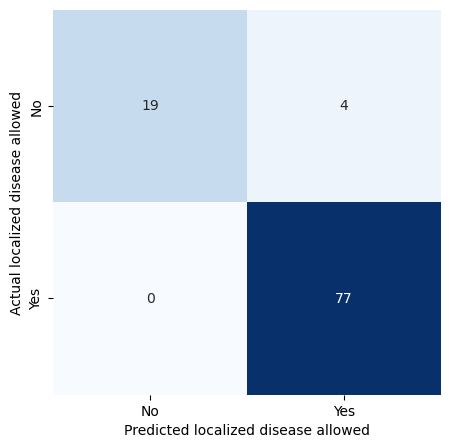

In [34]:
# Create confusion matrix of predicted and actual values for LOCAL using combined method
confusion_matrix = pd.crosstab(df_test["LOCAL"], df_test["LOCAL_PREDICTED_COMBINED"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted localized disease allowed")
plt.ylabel("Actual localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_local_combined.png", dpi=300, bbox_inches="tight")

In [35]:
# Calculate the accuracy of the combined prediction for LOCAL
accuracy_local_combined = (
    np.sum(df_test["LOCAL"] == df_test["LOCAL_PREDICTED_COMBINED"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_local_combined_std = np.sqrt(
    accuracy_local_combined * (1 - accuracy_local_combined) / df_test.shape[0]
)
accuracy_local_combined_CI = 1.96 * accuracy_local_combined_std
print(
    f"Accuracy of combined prediction for LOCAL: {accuracy_local_combined:.2f} (95% CI: {accuracy_local_combined - accuracy_local_combined_CI:.2f} - {accuracy_local_combined + accuracy_local_combined_CI:.2f})"
)

# Calculate the precision of the combined prediction for LOCAL
precision_local_combined = (
    np.sum(
        (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_COMBINED"] == 1)
    )
    / np.sum(df_test["LOCAL_PREDICTED_COMBINED"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_local_combined_std = np.sqrt(
    precision_local_combined * (1 - precision_local_combined) / np.sum(df_test["LOCAL_PREDICTED_COMBINED"] == 1)
)
precision_local_combined_CI = 1.96 * precision_local_combined_std
print(f"Precision of combined prediction for LOCAL: {precision_local_combined:.2f} (95% CI: {precision_local_combined - precision_local_combined_CI:.2f} - {precision_local_combined + precision_local_combined_CI:.2f})")

# Calculate the recall of the combined prediction for LOCAL
recall_local_combined = (
    np.sum(
        (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_COMBINED"] == 1)
    )
    / np.sum(df_test["LOCAL"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_local_combined_std = np.sqrt(
    recall_local_combined * (1 - recall_local_combined) / np.sum(df_test["LOCAL"] == 1)
)
recall_local_combined_CI = 1.96 * recall_local_combined_std
print(
    f"Recall of combined prediction for LOCAL: {recall_local_combined:.2f} (95% CI: {recall_local_combined - recall_local_combined_CI:.2f} - {recall_local_combined + recall_local_combined_CI:.2f})"
)

# Calculate the F1 score of the combined prediction for LOCAL
f1_local_combined = 2 * precision_local_combined * recall_local_combined / (precision_local_combined + recall_local_combined)

# Estimate the 95 % confidence interval for the F1 score
f1_local_combined_std = np.sqrt(
    f1_local_combined * (1 - f1_local_combined) / df_test.shape[0]
)
f1_local_combined_CI = 1.96 * f1_local_combined_std
print(f"F1 score of combined prediction for LOCAL: {f1_local_combined:.2f} (95% CI: {f1_local_combined - f1_local_combined_CI:.2f} - {f1_local_combined + f1_local_combined_CI:.2f})")

Accuracy of combined prediction for LOCAL: 0.96 (95% CI: 0.92 - 1.00)
Precision of combined prediction for LOCAL: 0.95 (95% CI: 0.90 - 1.00)
Recall of combined prediction for LOCAL: 1.00 (95% CI: 1.00 - 1.00)
F1 score of combined prediction for LOCAL: 0.97 (95% CI: 0.94 - 1.01)


In [36]:
# Calculate the accuracy per family of the combined prediction for LOCAL
accuracy_local_combined_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["LOCAL"] == x["LOCAL_PREDICTED_COMBINED"]) / x.shape[0]
)

# Calculate the precision per family of the combined prediction for LOCAL
precision_local_combined_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_COMBINED"] == 1)) / np.sum(x["LOCAL_PREDICTED_COMBINED"] == 1)
)

# Calculate the recall per family of the combined prediction for LOCAL
recall_local_combined_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_COMBINED"] == 1)) / np.sum(x["LOCAL"] == 1)
)

# Calculate the F1 score per family of the combined prediction for LOCAL

f1_local_combined_per_family = 2 * precision_local_combined_per_family * recall_local_combined_per_family / (precision_local_combined_per_family + recall_local_combined_per_family)
# Round the F1 values to two decimal places
f1_local_combined_per_family = f1_local_combined_per_family.round(2)
f1_local_combined_per_family

family
All                     1.00
Breast/Gynecological    1.00
Gastrointestinal        0.92
Head & neck             1.00
Lung/Thoracic           0.91
Neuro                   1.00
Skin/Soft tissue        0.93
Urogenital              1.00
dtype: float64

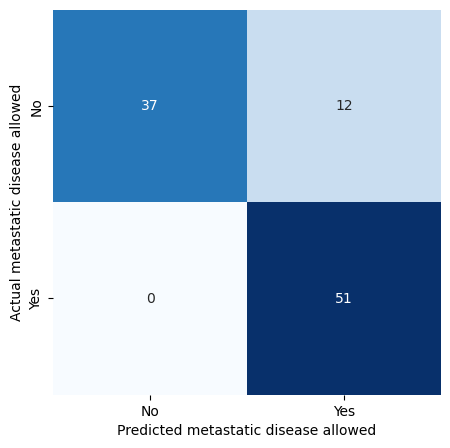

In [37]:
# Create confusion matrix of predicted and actual values for METASTATIC using combined method
confusion_matrix = pd.crosstab(df_test["METASTATIC"], df_test["METASTATIC_PREDICTED_COMBINED"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted metastatic disease allowed")
plt.ylabel("Actual metastatic disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_metastatic_combined.png", dpi=300, bbox_inches="tight")


In [38]:
# Calculate the accuracy of the combined prediction for METASTATIC
accuracy_metastatic_combined = (
    np.sum(df_test["METASTATIC"] == df_test["METASTATIC_PREDICTED_COMBINED"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_metastatic_combined_std = np.sqrt(
    accuracy_metastatic_combined * (1 - accuracy_metastatic_combined) / df_test.shape[0]
)
accuracy_metastatic_combined_CI = 1.96 * accuracy_metastatic_combined_std
print(
    f"Accuracy of combined prediction for METASTATIC: {accuracy_metastatic_combined:.2f} (95% CI: {accuracy_metastatic_combined - accuracy_metastatic_combined_CI:.2f} - {accuracy_metastatic_combined + accuracy_metastatic_combined_CI:.2f})"
)

# Calculate the precision of the combined prediction for METASTATIC
precision_metastatic_combined = (
    np.sum(
        (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_COMBINED"] == 1)
    )
    / np.sum(df_test["METASTATIC_PREDICTED_COMBINED"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_metastatic_combined_std = np.sqrt(
    precision_metastatic_combined * (1 - precision_metastatic_combined) / np.sum(df_test["METASTATIC_PREDICTED_COMBINED"] == 1)
)
precision_metastatic_combined_CI = 1.96 * precision_metastatic_combined_std
print(f"Precision of combined prediction for METASTATIC: {precision_metastatic_combined:.2f} (95% CI: {precision_metastatic_combined - precision_metastatic_combined_CI:.2f} - {precision_metastatic_combined + precision_metastatic_combined_CI:.2f})")

# Calculate the recall of the combined prediction for METASTATIC
recall_metastatic_combined = (
    np.sum(
        (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_COMBINED"] == 1)
    )
    / np.sum(df_test["METASTATIC"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_metastatic_combined_std = np.sqrt(
    recall_metastatic_combined * (1 - recall_metastatic_combined) / np.sum(df_test["METASTATIC"] == 1)
)
recall_metastatic_combined_CI = 1.96 * recall_metastatic_combined_std
print(
    f"Recall of combined prediction for METASTATIC: {recall_metastatic_combined:.2f} (95% CI: {recall_metastatic_combined - recall_metastatic_combined_CI:.2f} - {recall_metastatic_combined + recall_metastatic_combined_CI:.2f})"
)

# Calculate the F1 score of the combined prediction for METASTATIC
f1_metastatic_combined = 2 * precision_metastatic_combined * recall_metastatic_combined / (precision_metastatic_combined + recall_metastatic_combined)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_combined_std = np.sqrt(
    f1_metastatic_combined * (1 - f1_metastatic_combined) / df_test.shape[0]
)
f1_metastatic_combined_CI = 1.96 * f1_metastatic_combined_std
print(f"F1 score of combined prediction for METASTATIC: {f1_metastatic_combined:.2f} (95% CI: {f1_metastatic_combined - f1_metastatic_combined_CI:.2f} - {f1_metastatic_combined + f1_metastatic_combined_CI:.2f})")

Accuracy of combined prediction for METASTATIC: 0.88 (95% CI: 0.82 - 0.94)
Precision of combined prediction for METASTATIC: 0.81 (95% CI: 0.71 - 0.91)
Recall of combined prediction for METASTATIC: 1.00 (95% CI: 1.00 - 1.00)
F1 score of combined prediction for METASTATIC: 0.89 (95% CI: 0.83 - 0.95)


In [39]:
# Calculate the accuracy per family of the combined prediction for METASTATIC
accuracy_metastatic_combined_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["METASTATIC"] == x["METASTATIC_PREDICTED_COMBINED"]) / x.shape[0]
)

# Calculate the precision per family of the combined prediction for METASTATIC
precision_metastatic_combined_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_COMBINED"] == 1)) / np.sum(x["METASTATIC_PREDICTED_COMBINED"] == 1)
)

# Calculate the recall per family of the combined prediction for METASTATIC
recall_metastatic_combined_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_COMBINED"] == 1)) / np.sum(x["METASTATIC"] == 1)
)

# Calculate the F1 score per family of the combined prediction for METASTATIC
f1_metastatic_combined_per_family = 2 * precision_metastatic_combined_per_family * recall_metastatic_combined_per_family / (precision_metastatic_combined_per_family + recall_metastatic_combined_per_family)
# Round the F1 values to two decimal places
f1_metastatic_combined_per_family = f1_metastatic_combined_per_family.round(2)
f1_metastatic_combined_per_family

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/1349172256.py:8: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_COMBINED"] == 1)) / np.sum(x["METASTATIC_PREDICTED_COMBINED"] == 1)
/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/1349172256.py:13: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_COMBINED"] == 1)) / np.sum(x["METASTATIC"] == 1)


family
All                     1.00
Breast/Gynecological    0.92
Gastrointestinal        0.90
Head & neck             0.80
Lung/Thoracic           1.00
Neuro                    NaN
Skin/Soft tissue        0.83
Urogenital              0.80
dtype: float64

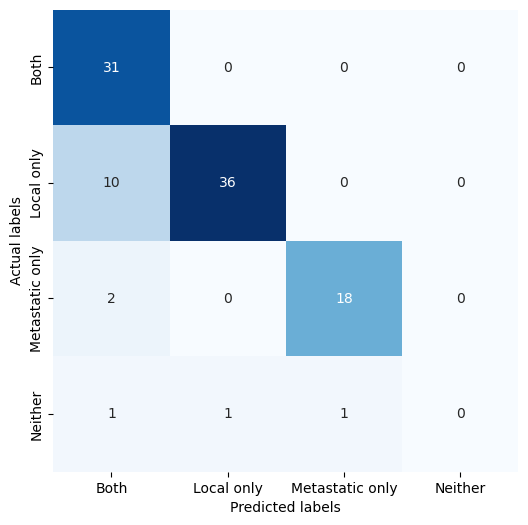

In [40]:
# Create the confusion matrix of predicted and actual values for combined labels
confusion_matrix = pd.crosstab(
    df_test["ALL_LABELS"], df_test["ALL_LABELS_PREDICTIONS_COMBINED"]
)

# Add a column called "Neither" and fill it with zeros if it does not exist
if "Neither" not in confusion_matrix.columns:
    confusion_matrix["Neither"] = 0

# Plot the confusion matrix
fig = plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("plots/confusion_matrix_all_labels_combined.png", dpi=300, bbox_inches="tight")

In [53]:
# Calculate the accuracy of the combined model for all labels
accuracy_combined_combined = (
    np.sum(df_test["ALL_LABELS"] == df_test["ALL_LABELS_PREDICTIONS_COMBINED"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_combined_combined_std = np.sqrt(
    accuracy_combined_combined * (1 - accuracy_combined_combined) / df_test.shape[0]
)
accuracy_combined_combined_CI = 1.96 * accuracy_combined_combined_std
print(
    f"Accuracy of combined prediction for Both: {accuracy_combined_combined:.2f} (95% CI: {accuracy_combined_combined - accuracy_combined_combined_CI:.2f} - {accuracy_combined_combined + accuracy_combined_combined_CI:.2f})"
)
print("##############################################")

# Calculate the precision of the combined model for Both
precision_both_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Both") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Both")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Both")
)

# Estimate the 95 % confidence interval for the precision
precision_both_combined_std = np.sqrt(
    precision_both_combined * (1 - precision_both_combined) / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Both")
)
precision_both_combined_CI = 1.96 * precision_both_combined_std
print(f"Precision of combined prediction for Both: {precision_both_combined:.2f} (95% CI: {precision_both_combined - precision_both_combined_CI:.2f} - {precision_both_combined + precision_both_combined_CI:.2f})")

# Calculate the recall of the combined model for Both
recall_both_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Both") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Both")
    )
    / np.sum(df_test["ALL_LABELS"] == "Both")
)

# Estimate the 95 % confidence interval for the recall
recall_both_combined_std = np.sqrt(
    recall_both_combined * (1 - recall_both_combined) / np.sum(df_test["ALL_LABELS"] == "Both")
)
recall_both_combined_CI = 1.96 * recall_both_combined_std
print(
    f"Recall of combined prediction for Both: {recall_both_combined:.2f} (95% CI: {recall_both_combined - recall_both_combined_CI:.2f} - {recall_both_combined + recall_both_combined_CI:.2f})"
)

# Calculate the F1 score of the combined model for Both
f1_both_combined = 2 * precision_both_combined * recall_both_combined / (precision_both_combined + recall_both_combined)

# Estimate the 95 % confidence interval for the F1 score
f1_both_combined_std = np.sqrt(
    f1_both_combined * (1 - f1_both_combined) / df_test.shape[0]
)
f1_both_combined_CI = 1.96 * f1_both_combined_std
print(f"F1 score of combined prediction for Both: {f1_both_combined:.2f} (95% CI: {f1_both_combined - f1_both_combined_CI:.2f} - {f1_both_combined + f1_both_combined_CI:.2f}")
print("##############################################")

# Calculate the precision of the combined model for Local only
precision_local_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Local_only") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Local_only")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Local_only")
)


# Estimate the 95 % confidence interval for the precision
precision_local_combined_std = np.sqrt(
    precision_local_combined * (1 - precision_local_combined) / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Local_only")
)
precision_local_combined_CI = 1.96 * precision_local_combined_std
print(f"Precision of combined prediction for Local only: {precision_local_combined:.2f} (95% CI: {precision_local_combined - precision_local_combined_CI:.2f} - {precision_local_combined + precision_local_combined_CI:.2f})")

# Calculate the recall of the combined model for Local only
recall_local_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Local_only") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Local_only")
    )
    / np.sum(df_test["ALL_LABELS"] == "Local_only")
)

# Estimate the 95 % confidence interval for the recall
recall_local_combined_std = np.sqrt(
    recall_local_combined * (1 - recall_local_combined) / np.sum(df_test["ALL_LABELS"] == "Local_only")
)
recall_local_combined_CI = 1.96 * recall_local_combined_std
print(
    f"Recall of combined prediction for Local only: {recall_local_combined:.2f} (95% CI: {recall_local_combined - recall_local_combined_CI:.2f} - {recall_local_combined + recall_local_combined_CI:.2f})"
)

# Calculate the F1 score of the combined model for Local only
f1_local_combined = 2 * precision_local_combined * recall_local_combined / (precision_local_combined + recall_local_combined)

# Estimate the 95 % confidence interval for the F1 score
f1_local_combined_std = np.sqrt(
    f1_local_combined * (1 - f1_local_combined) / df_test.shape[0]
)
f1_local_combined_CI = 1.96 * f1_local_combined_std
print(f"F1 score of combined prediction for Local only: {f1_local_combined:.2f} (95% CI: {f1_local_combined - f1_local_combined_CI:.2f} - {f1_local_combined + f1_local_combined_CI:.2f}")
print("##############################################")

# Calculate the precision of the combined model for Metastatic only
precision_metastatic_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Metastatic_only") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Metastatic_only")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Metastatic_only")
)

# Estimate the 95 % confidence interval for the precision
precision_metastatic_combined_std = np.sqrt(
    precision_metastatic_combined * (1 - precision_metastatic_combined) / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Metastatic_only")
)
precision_metastatic_combined_CI = 1.96 * precision_metastatic_combined_std
print(f"Precision of combined prediction for Metastatic only: {precision_metastatic_combined:.2f} (95% CI: {precision_metastatic_combined - precision_metastatic_combined_CI:.2f} - {precision_metastatic_combined + precision_metastatic_combined_CI:.2f})")

# Calculate the recall of the combined model for Metastatic only
recall_metastatic_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Metastatic_only") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Metastatic_only")
    )
    / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")
)

# Estimate the 95 % confidence interval for the recall
recall_metastatic_combined_std = np.sqrt(
    recall_metastatic_combined * (1 - recall_metastatic_combined) / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")
)
recall_metastatic_combined_CI = 1.96 * recall_metastatic_combined_std
print(
    f"Recall of combined prediction for Metastatic only: {recall_metastatic_combined:.2f} (95% CI: {recall_metastatic_combined - recall_metastatic_combined_CI:.2f} - {recall_metastatic_combined + recall_metastatic_combined_CI:.2f})"
)

# Calculate the F1 score of the combined model for Metastatic only
f1_metastatic_combined = 2 * precision_metastatic_combined * recall_metastatic_combined / (precision_metastatic_combined + recall_metastatic_combined)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_combined_std = np.sqrt(
    f1_metastatic_combined * (1 - f1_metastatic_combined) / df_test.shape[0]
)
f1_metastatic_combined_CI = 1.96 * f1_metastatic_combined_std
print(f"F1 score of combined prediction for Metastatic only: {f1_metastatic_combined:.2f} (95% CI: {f1_metastatic_combined - f1_metastatic_combined_CI:.2f} - {f1_metastatic_combined + f1_metastatic_combined_CI:.2f})")
print("##############################################")

# Calculate the precision of the combined model for Neither
precision_neither_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Neither")
    )
    / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Neither")
)

# Estimate the 95 % confidence interval for the precision
precision_neither_combined_std = np.sqrt(
    precision_neither_combined * (1 - precision_neither_combined) / np.sum(df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Neither")
)
precision_neither_combined_CI = 1.96 * precision_neither_combined_std
print(f"Precision of combined prediction for Neither: {precision_neither_combined:.2f} (95% CI: {precision_neither_combined - precision_neither_combined_CI:.2f} - {precision_neither_combined + precision_neither_combined_CI:.2f})")

# Calculate the recall of the combined model for Neither
recall_neither_combined = (
    np.sum(
        (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_PREDICTIONS_COMBINED"] == "Neither")
    )
    / np.sum(df_test["ALL_LABELS"] == "Neither")
)

# Estimate the 95 % confidence interval for the recall
recall_neither_combined_std = np.sqrt(
    recall_neither_combined * (1 - recall_neither_combined) / np.sum(df_test["ALL_LABELS"] == "Neither")
)
recall_neither_combined_CI = 1.96 * recall_neither_combined_std

print(
    f"Recall of combined prediction for Neither: {recall_neither_combined:.2f} (95% CI: {recall_neither_combined - recall_neither_combined_CI:.2f} - {recall_neither_combined + recall_neither_combined_CI:.2f})"
)

# Calculate the F1 score of the combined model for Neither
f1_neither_combined = 2 * precision_neither_combined * recall_neither_combined / (precision_neither_combined + recall_neither_combined)

# Estimate the 95 % confidence interval for the F1 score
f1_neither_combined_std = np.sqrt(
    f1_neither_combined * (1 - f1_neither_combined) / df_test.shape[0]
)
f1_neither_combined_CI = 1.96 * f1_neither_combined_std
print(f"F1 score of combined prediction for Neither: {f1_neither_combined:.2f} (95% CI: {f1_neither_combined - f1_neither_combined_CI:.2f} - {f1_neither_combined + f1_neither_combined_CI:.2f})")

Accuracy of combined prediction for Both: 0.85 (95% CI: 0.78 - 0.92)
##############################################
Precision of combined prediction for Both: 0.70 (95% CI: 0.57 - 0.84)
Recall of combined prediction for Both: 1.00 (95% CI: 1.00 - 1.00)
F1 score of combined prediction for Both: 0.83 (95% CI: 0.75 - 0.90
##############################################
Precision of combined prediction for Local only: 0.97 (95% CI: 0.92 - 1.03)
Recall of combined prediction for Local only: 0.78 (95% CI: 0.66 - 0.90)
F1 score of combined prediction for Local only: 0.87 (95% CI: 0.80 - 0.93
##############################################
Precision of combined prediction for Metastatic only: 0.95 (95% CI: 0.85 - 1.05)
Recall of combined prediction for Metastatic only: 0.90 (95% CI: 0.77 - 1.03)
F1 score of combined prediction for Metastatic only: 0.92 (95% CI: 0.87 - 0.98)
##############################################
Precision of combined prediction for Neither: nan (95% CI: nan - nan)
Recall

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72970/1654664810.py:149: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(
